# End-to-End Data Analysis System for Monitoring Climate Change Impacts in Nepal

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')


## 1. Load the dataset

In [48]:


df = pd.read_csv('../data/Weather_&_Climate/district_wise/climate_data_nepal_district_wise_monthly.csv')

print(df.shape)
print(df.columns)
df.head()


(29016, 24)
Index(['DATE', 'YEAR', 'MONTH', 'DISTRICT', 'LAT', 'LON', 'PRECTOT', 'PS',
       'QV2M', 'RH2M', 'T2M', 'T2MWET', 'T2M_MAX', 'T2M_MIN', 'T2M_RANGE',
       'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN', 'WS10M_RANGE', 'WS50M',
       'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE'],
      dtype='object')


,DATE,YEAR,MONTH,DISTRICT,LAT,LON,PRECTOT,PS,QV2M,RH2M,...,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE
0,1981-01-31,1981,1,Arghakhanchi,27.9,83.2,67.31,93.78,5.28,53.09,...,10.03,11.19,2.01,3.39,0.81,2.59,2.70,4.22,1.06,3.16
1,1981-02-28,1981,2,Arghakhanchi,27.9,83.2,3.37,93.52,5.13,40.88,...,13.08,15.10,2.58,4.88,0.95,3.94,3.51,5.62,1.09,4.53
2,1981-03-31,1981,3,Arghakhanchi,27.9,83.2,26.02,93.40,5.91,35.84,...,13.52,20.58,2.73,4.67,1.02,3.65,3.73,5.72,1.38,4.34
3,1981-04-30,1981,4,Arghakhanchi,27.9,83.2,46.15,93.03,6.52,29.81,...,15.03,25.63,2.89,4.78,1.07,3.72,3.82,5.66,1.35,4.31
4,1981-05-31,1981,5,Arghakhanchi,27.9,83.2,69.45,92.75,9.95,37.25,...,13.43,29.99,2.69,4.40,0.93,3.47,3.52,5.29,1.30,4.00


## 2. Initial Data Cleaning

date           0.0
year           0.0
month          0.0
district       0.0
lat            0.0
lon            0.0
prectot        0.0
ps             0.0
qv2m           0.0
rh2m           0.0
t2m            0.0
t2mwet         0.0
t2m_max        0.0
t2m_min        0.0
t2m_range      0.0
ts             0.0
ws10m          0.0
ws10m_max      0.0
ws10m_min      0.0
ws10m_range    0.0
ws50m          0.0
ws50m_max      0.0
ws50m_min      0.0
ws50m_range    0.0
dtype: float64


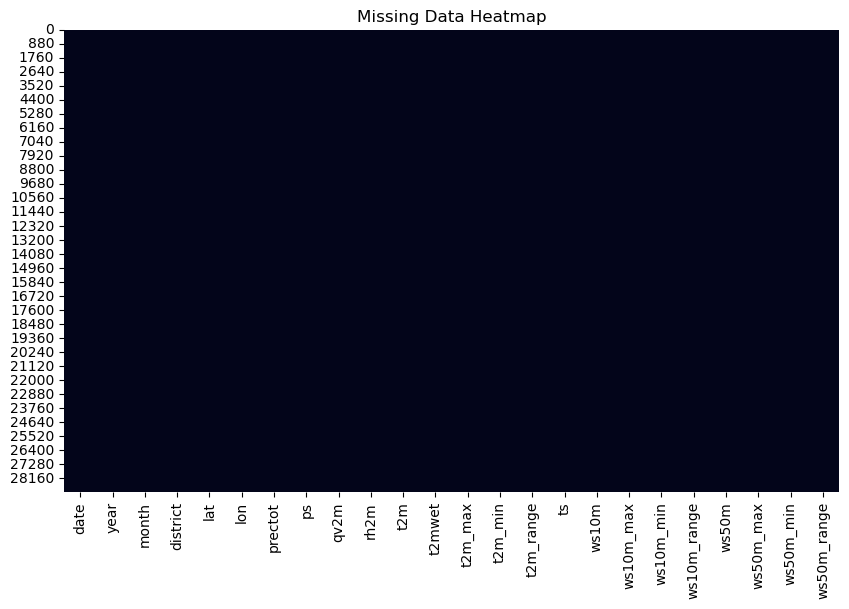

In [49]:

# Standardize column names
df.columns = df.columns.str.strip().str.lower()

# Drop duplicates
df = df.drop_duplicates()

# Check missingness
missing = df.isnull().mean().sort_values(ascending=False)
print(missing)

# Quick visual check
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Data Heatmap")
plt.show()


## 3. Impute Missing Values

In [50]:
def impute_columns(df, exclude_cols=['district', 'date', 'lat', 'lon']):
    df_copy = df.copy()

    # Ensure 'date' is datetime
    df_copy['date'] = pd.to_datetime(df_copy['date'], errors='coerce')

    climate_cols = [col for col in df.columns if col not in exclude_cols]

    for col in climate_cols:
        # Interpolate missing values linearly
        df_copy[col] = df_copy[col].interpolate(method='linear', limit_direction='both')
        
        # Fill remaining missing with monthly mean
        df_copy['month'] = df_copy['date'].dt.month
        monthly_avg = df_copy.groupby('month')[col].transform('mean')
        df_copy[col] = df_copy[col].fillna(monthly_avg)

    df_copy = df_copy.drop(columns='month')
    return df_copy


## 4. Add Georeferencing

In [51]:

if 'lat' not in df.columns or 'lon' not in df.columns:
    np.random.seed(42)
    df['lat'] = np.random.uniform(26.3, 30.4, size=len(df))
    df['lon'] = np.random.uniform(80.0, 88.2, size=len(df))


## 5. Final Validation Checks

In [52]:
# Validation checks
assert df['date'].isnull().sum() == 0, "Missing dates"
assert df.duplicated().sum() == 0, "Duplicate records"
assert df['lat'].between(26.3, 30.4).all(), "Latitude out of Nepal bounds"
assert df['lon'].between(80.0, 88.2).all(), "Longitude out of Nepal bounds"

print(" All validation checks passed!")


 All validation checks passed!


## 6. Save Processed Data

In [53]:
# Save processed clean file
df.to_csv('../data/Weather_&_Climate/district_wise/processed_climate_data_nepal.csv', index=False)

print("Processed file saved successfully!")


Processed file saved successfully!


# Part B: Exploratory Data Analysis (EDA)

### 1. Import Libraries for EDA

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
import geopandas as gpd

# Load processed data
df = pd.read_csv('../data/Weather_&_Climate/district_wise/processed_climate_data_nepal.csv')

# Quick check
df['date'] = pd.to_datetime(df['date'], errors='coerce', infer_datetime_format=True)

df.head()


,date,year,month,district,lat,lon,prectot,ps,qv2m,rh2m,...,t2m_range,ts,ws10m,ws10m_max,ws10m_min,ws10m_range,ws50m,ws50m_max,ws50m_min,ws50m_range
0,1981-01-31,1981,1,Arghakhanchi,27.9,83.2,67.31,93.78,5.28,53.09,...,10.03,11.19,2.01,3.39,0.81,2.59,2.70,4.22,1.06,3.16
1,1981-02-28,1981,2,Arghakhanchi,27.9,83.2,3.37,93.52,5.13,40.88,...,13.08,15.10,2.58,4.88,0.95,3.94,3.51,5.62,1.09,4.53
2,1981-03-31,1981,3,Arghakhanchi,27.9,83.2,26.02,93.40,5.91,35.84,...,13.52,20.58,2.73,4.67,1.02,3.65,3.73,5.72,1.38,4.34
3,1981-04-30,1981,4,Arghakhanchi,27.9,83.2,46.15,93.03,6.52,29.81,...,15.03,25.63,2.89,4.78,1.07,3.72,3.82,5.66,1.35,4.31
4,1981-05-31,1981,5,Arghakhanchi,27.9,83.2,69.45,92.75,9.95,37.25,...,13.43,29.99,2.69,4.40,0.93,3.47,3.52,5.29,1.30,4.00


### 2. Analyze Temperature Trends Across Regions and Elevations

In [55]:
import plotly.express as px

# Prepare the same data
temp_trend = df.groupby(['district', pd.Grouper(key='date', freq='Y')])['t2m'].mean().reset_index()


districts = temp_trend['district'].unique()


temp_trend_subset = temp_trend[temp_trend['district'].isin(districts)]

# Now plot with Plotly
fig = px.line(
    temp_trend_subset, 
    x='date', 
    y='t2m', 
    color='district', 
    markers=True, 
    title='Temperature Trend by District (hover to see values)',
    labels={'t2m': 'Average Temperature (°C)', 'date': 'Year'}
)

fig.update_traces(mode="lines+markers", hovertemplate='Year: %{x|%Y}<br>Temp: %{y:.2f}°C')
fig.update_layout(hovermode='x unified')

fig.show()


### 3. Visualize Precipitation Patterns and Changes Over Time

In [56]:
import plotly.express as px

# Average precipitation over Nepal by year
precip_trend = df.groupby(pd.Grouper(key='date', freq='Y'))['prectot'].mean().reset_index()

# Plot with Plotly
fig = px.line(
    precip_trend,
    x='date',
    y='prectot',
    title='Average Precipitation Over Nepal (Annual)',
    labels={'prectot': 'Total Annual Precipitation (mm)', 'date': 'Year'},
    markers=True
)

fig.update_traces(mode="lines+markers", hovertemplate='Year: %{x|%Y}<br>Precip: %{y:.2f} mm')
fig.update_layout(hovermode='x unified')

fig.show()


### 4. Identify Extreme Weather Event Frequency and Intensity Changes


In [85]:
# Define thresholds (or reuse previous ones if defined)
precip_threshold = df['prectot'].quantile(0.95)  # Top 5% precipitation
temp_high_threshold = 38  # degrees Celsius
temp_low_threshold = 0   # degrees Celsius
wind_speed_threshold = 15  # m/s

# Step 1: Create Extreme Condition Flags
df['extreme_precip'] = df['prectot'] > precip_threshold
df['extreme_heat'] = df['t2m_max'] > temp_high_threshold
df['extreme_cold'] = df['t2m_min'] < temp_low_threshold
df['extreme_wind'] = df['ws10m_max'] > wind_speed_threshold

# Step 2: Classify Event Based on Which Extreme Happened
def classify_event(row):
    if row['extreme_precip']:
        return 'Heavy Rain'
    elif row['extreme_heat']:
        return 'Heatwave'
    elif row['extreme_cold']:
        return 'Coldwave'
    elif row['extreme_wind']:
        return 'Windstorm'
    else:
        return 'Normal'

# Apply classification
df['event_type'] = df.apply(classify_event, axis=1)

# Keep only real extreme events
extreme_events = df[df['event_type'] != 'Normal']

# Step 3: Group by year and event type
extreme_summary = extreme_events.groupby([pd.Grouper(key='date', freq='Y'), 'event_type']).size().reset_index(name='count')

# Step 4: Plot
fig = px.bar(
    extreme_summary,
    x='date',
    y='count',
    color='event_type',
    title='Extreme Weather Events by Type Over Years',
    labels={'count': 'Number of Events', 'date': 'Year', 'event_type': 'Event Type'},
)

fig.update_traces(hovertemplate='Year: %{x|%Y}<br>Type: %{customdata[0]}<br>Count: %{y}')
fig.update_layout(xaxis_tickangle=-45, barmode='stack')
fig.show()



In [ ]:
# Extract year from date
extreme_events['year'] = extreme_events['date'].dt.year

# Group by district, event type, and year
district_extreme_summary = extreme_events.groupby(['district', 'event_type', 'year']).size().reset_index(name='count')

# Check
print(district_extreme_summary.head(10))

import plotly.express as px

fig = px.bar(
    district_extreme_summary,
    x='district',
    y='count',
    color='event_type',
    animation_frame='year',  
    title='District-wise Extreme Weather Events by Type and Year',
    labels={'count': 'Number of Events', 'district': 'District', 'event_type': 'Event Type', 'year': 'Year'},
)

fig.update_layout(
    xaxis_tickangle=-45,
    barmode='group',
    transition={'duration': 500},
)
fig.show()

# Mock: Average lat/lon per district (already done before)
district_coords = df.groupby('district')[['lat', 'lon']].mean().reset_index()

# Merge with extreme event counts
district_map_df = district_extreme_summary.merge(district_coords, on='district', how='left')

# Plot map
fig = px.scatter_geo(
    district_map_df,
    lat='lat',
    lon='lon',
    text='district',
    size='count',
    color='event_type',
    animation_frame='year',
    scope='asia',
    title='Extreme Weather Events Map Across Nepal Districts Over Years',
    labels={'count': 'Extreme Event Count', 'district': 'District', 'year': 'Year'},
)

fig.update_layout(
    geo=dict(
        center=dict(lat=28.3949, lon=84.1240),
        projection_scale=5,
        showland=True,
    ),
    width=1200, 
    height=800, 
    margin={"r":0,"t":50,"l":0,"b":0}
)


fig.show()



       district  event_type    year  count
0  Arghakhanchi    Heatwave  1984.0      1
1  Arghakhanchi    Heatwave  1987.0      1
2  Arghakhanchi    Heatwave  1988.0      1
3  Arghakhanchi    Heatwave  1991.0      1
4  Arghakhanchi    Heatwave  1994.0      1
5  Arghakhanchi    Heatwave  1995.0      1
6  Arghakhanchi    Heatwave  1996.0      1
7  Arghakhanchi    Heatwave  2012.0      2
8  Arghakhanchi  Heavy Rain  1981.0      2
9  Arghakhanchi  Heavy Rain  1982.0      1


In [87]:
# Already grouped by event_type and year before
extreme_frequency = extreme_events.groupby([pd.Grouper(key='date', freq='Y'), 'event_type']).size().reset_index(name='event_count')

# Plot frequency trend
import plotly.express as px

fig = px.line(
    extreme_frequency,
    x='date',
    y='event_count',
    color='event_type',
    markers=True,
    title='Extreme Event Frequency Over Years by Type',
    labels={'event_count': 'Number of Events', 'date': 'Year', 'event_type': 'Type'}
)

fig.update_layout(xaxis_tickangle=-45)
fig.show()

# For each event type, define intensity based on the causing variable
def calculate_intensity(row):
    if row['event_type'] == 'Heavy Rain':
        return row['prectot']
    elif row['event_type'] == 'Heatwave':
        return row['t2m_max']
    elif row['event_type'] == 'Coldwave':
        return row['t2m_min']
    elif row['event_type'] == 'Windstorm':
        return row['ws10m_max']
    else:
        return np.nan

# Apply
extreme_events['intensity'] = extreme_events.apply(calculate_intensity, axis=1)

# Group average intensity per year and event type
extreme_intensity = extreme_events.groupby([pd.Grouper(key='date', freq='Y'), 'event_type'])['intensity'].mean().reset_index()

# Plot intensity trend
fig = px.line(
    extreme_intensity,
    x='date',
    y='intensity',
    color='event_type',
    markers=True,
    title='Extreme Event Intensity Over Years by Type',
    labels={'intensity': 'Average Intensity', 'date': 'Year', 'event_type': 'Type'}
)

fig.update_layout(xaxis_tickangle=-45)
fig.show()


# Statistical Testing for Climate Trends

In [92]:
import plotly.express as px

fig = px.bar(
    mk_results_df,
    x='Event Type',
    y="Sen's Slope",
    color='Significant',
    text="Sen's Slope",
    title="Sen's Slope of Trend for Extreme Events (Mann-Kendall Test)",
    labels={"Sen's Slope": "Rate of Change per Year"},
    color_discrete_map={"Yes": "green", "No": "red"}
)

fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(
    yaxis_title="Sen's Slope (events/year)",
    xaxis_title="Extreme Event Type",
    uniformtext_minsize=8,
    uniformtext_mode='hide',
)
fig.show()


In [93]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(
    header=dict(values=list(mk_results_df.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[mk_results_df[col] for col in mk_results_df.columns],
               fill_color='lavender',
               align='left'))
])

fig.update_layout(title="Mann-Kendall Test Results for Extreme Events")
fig.show()


In [96]:
import matplotlib.pyplot as plt
import numpy as np
import pymannkendall as mk

# --- Function to plot observed vs Sen's slope line ---
def plot_sen_slope(event_type):
    # Filter data for the given event type
    yearly_data = extreme_events[extreme_events['event_type'] == event_type] \
                    .groupby('year').size().reset_index(name='event_count')

    # Check if enough years to plot
    if yearly_data['year'].nunique() < 2:
        print(f" Not enough data points to plot Sen's slope for {event_type}. Skipping...")
        return

    # Apply Mann-Kendall
    result = mk.original_test(yearly_data['event_count'])

    # Extract years and events
    years = yearly_data['year'].values
    events = yearly_data['event_count'].values

    slope = result.slope

    # Calculate Sen's line safely
    # New method: y = slope * (year) + intercept
    intercept = np.median(events) - slope * np.median(years)
    sen_line = slope * years + intercept

    # --- Plot ---
    plt.figure(figsize=(10,6))
    plt.scatter(years, events, color='blue', label='Observed Events')
    plt.plot(years, sen_line, color='red', linestyle='--', label=f"Sen's Slope Line\nSlope: {slope:.2f} events/year")
    plt.title(f"Trend in {event_type} Events (Mann-Kendall Sen's Slope)")
    plt.xlabel('Year')
    plt.ylabel('Number of Events')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Print trend details
    print(f"Trend: {result.trend}")
    print(f"P-value: {result.p:.4f}")
    print(f"Tau: {result.Tau:.4f}")
    print(f"Sen's Slope: {result.slope:.4f}")
    print(f"Is trend significant? {'Yes' if result.p < 0.05 else 'No'}")


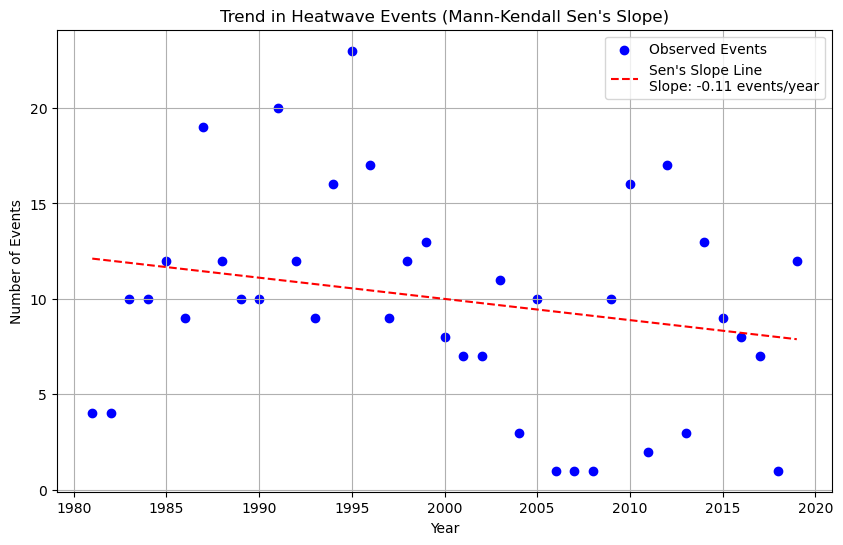

Trend: no trend
P-value: 0.1196
Tau: -0.1741
Sen's Slope: -0.1111
Is trend significant? No


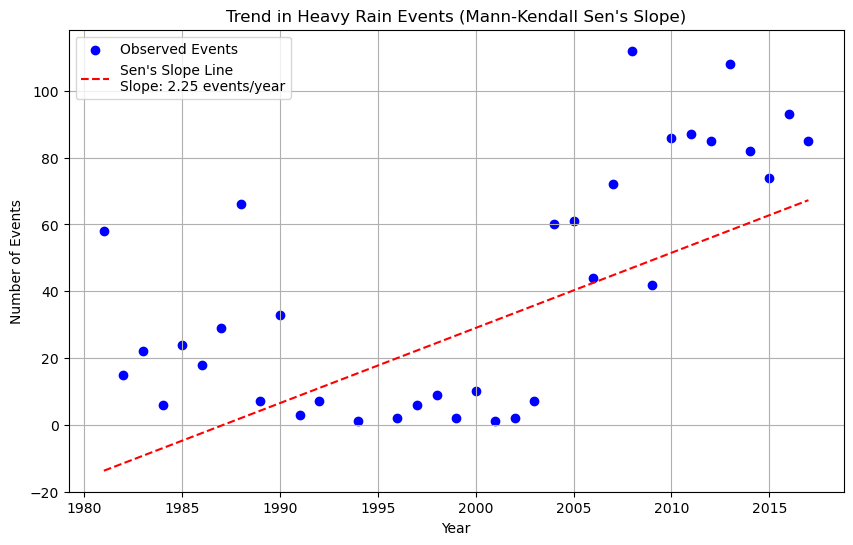

Trend: increasing
P-value: 0.0014
Tau: 0.3798
Sen's Slope: 2.2500
Is trend significant? Yes


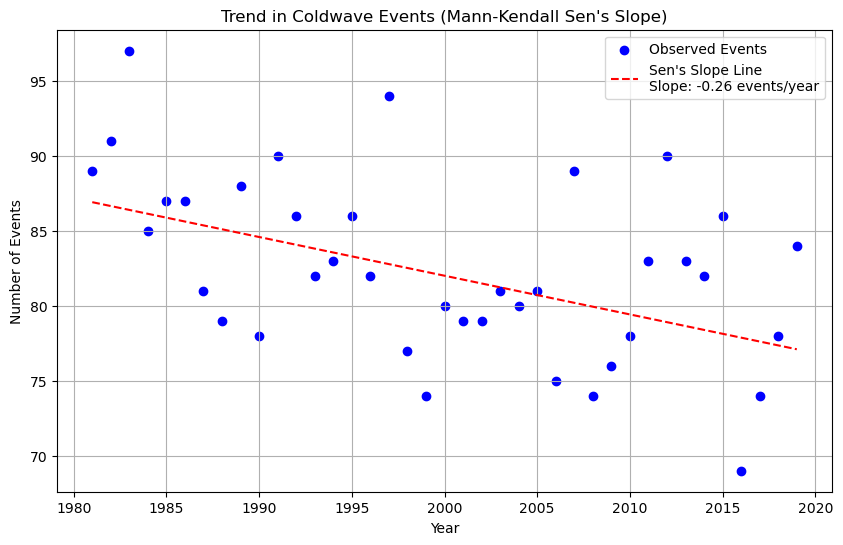

Trend: decreasing
P-value: 0.0059
Tau: -0.3077
Sen's Slope: -0.2581
Is trend significant? Yes
 Not enough data points to plot Sen's slope for Windstorm. Skipping...


In [97]:
plot_sen_slope('Heatwave')
plot_sen_slope('Heavy Rain')
plot_sen_slope('Coldwave')
plot_sen_slope('Windstorm')
